## Imports

In [ ]:
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, LeakyReLU, MaxPooling2D, Dropout, concatenate, UpSampling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend
import tensorflow as tf
print(tf.__version__)

def high_freq_mae(y_true, y_pred):
    freq = tf.range(512,dtype=tf.float32)
    
    weights = 1.0 + (freq / 512.0) * 4.0 
    
    weights = tf.reshape(weights, (1, 512, 1 ,1))
    
    mae = tf.abs(y_true - y_pred)
    weighted_mae = mae * weights

    return tf.reduce_mean(weighted_mae)

#Unet network
def unet(pretrained_weights = None,input_size = (512,512,1)):
    #size filter input
    size_filter_in = 64
    #normal initialization of weights
    kernel_init = 'he_normal'
    activation_layer = None
    inputs = Input(input_size)
    conv1 = Conv2D(size_filter_in, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(inputs)
    conv1 = LeakyReLU()(conv1)
    conv1 = Conv2D(size_filter_in, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv1)
    conv1 = LeakyReLU()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(size_filter_in*2, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(pool1)
    conv2 = LeakyReLU()(conv2)
    conv2 = Conv2D(size_filter_in*2, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv2)
    conv2 = LeakyReLU()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(size_filter_in*4, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(pool2)
    conv3 = LeakyReLU()(conv3)
    conv3 = Conv2D(size_filter_in*4, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv3)
    conv3 = LeakyReLU()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(size_filter_in*8, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(pool3)
    conv4 = LeakyReLU()(conv4)
    conv4 = Conv2D(size_filter_in*8, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv4)
    conv4 = LeakyReLU()(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(size_filter_in*16, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(pool4)
    conv5 = LeakyReLU()(conv5)
    conv5 = Conv2D(size_filter_in*16, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv5)
    conv5 = LeakyReLU()(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(size_filter_in*8, 2, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(UpSampling2D(size = (2,2))(drop5))
    up6 = LeakyReLU()(up6)
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(size_filter_in*8, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(merge6)
    conv6 = LeakyReLU()(conv6)
    conv6 = Conv2D(size_filter_in*8, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv6)
    conv6 = LeakyReLU()(conv6)

    up7 = Conv2D(size_filter_in*4, 2, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(UpSampling2D(size = (2,2))(conv6))
    up7 = LeakyReLU()(up7)
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(size_filter_in*4, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(merge7)
    conv7 = LeakyReLU()(conv7)
    conv7 = Conv2D(size_filter_in*4, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv7)
    conv7 = LeakyReLU()(conv7)

    up8 = Conv2D(size_filter_in*2, 2, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(UpSampling2D(size = (2,2))(conv7))
    up8 = LeakyReLU()(up8)
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(size_filter_in*2, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(merge8)
    conv8 = LeakyReLU()(conv8)
    conv8 = Conv2D(size_filter_in*2, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv8)
    conv8 = LeakyReLU()(conv8)

    up9 = Conv2D(size_filter_in, 2, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(UpSampling2D(size = (2,2))(conv8))
    up9 = LeakyReLU()(up9)
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(size_filter_in, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(merge9)
    conv9 = LeakyReLU()(conv9)
    conv9 = Conv2D(size_filter_in, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv9)
    conv9 = LeakyReLU()(conv9)

    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs,conv10)

    model.compile(optimizer = 'adam', loss = high_freq_mae, metrics = ['mae'])

    #model.summary()

    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

    return model


2.19.0


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/ML_audio/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import librosa
import os, inspect
import pathlib
# ==== paths ====
currentdir = os.getcwd()
datadir = f"{currentdir}/data"
# file_no_dolby = "ELO_1_raw.wav"
# file_dolby    = "ELO_1_clean.wav"
# file_no_dolby = "ELO_1-2.wav"
# file_dolby    = "ELO_1_clean-3.wav"
file_no_dolby = "AUDIO_all_2.wav"
file_dolby    = "AUDIO_all_clean_2.wav"

# ==== audio params ====
sr = 44100

# frame_length = 32768        # ~0.74 sec
# hop_length_frame = 32768   # 50% overlap

# # ==== spectrogram params ====
# dim_square_spec = 128
# n_fft = 255
# hop_length_fft = 256

frame_length = 262144
hop_length_frame = 131072

# ==== spectrogram params ====
dim_square_spec = 512
n_fft = 1023
hop_length_fft = 512


In [4]:
y_no_dolby, sr1 = librosa.load(
    os.path.join(root_path, file_no_dolby),
    sr=sr,
    mono=True
)

y_dolby, sr2 = librosa.load(
    os.path.join(root_path, file_dolby),
    sr=sr,
    mono=True
)

print("No Dolby length:", y_no_dolby.shape[0])
print("Dolby length   :", y_dolby.shape[0])


No Dolby length: 265235484
Dolby length   : 265235484


In [5]:
def audio_to_audio_frame_stack(sound_data, frame_length, hop_length_frame):
    """This function take an audio and split into several frame
       in a numpy matrix of size (nb_frame,frame_length)"""

    sequence_sample_length = sound_data.shape[0]

    sound_data_list = [sound_data[start:start + frame_length] for start in range(
    0, sequence_sample_length - frame_length + 1, hop_length_frame)]  # get sliding windows
    sound_data_array = np.vstack(sound_data_list)

    return sound_data_array

In [ ]:
class SlicedAudioGenerator(tf.keras.utils.Sequence):
    def __init__(self, noisy_data, clean_data, batch_size=16,
                 frame_length=262144, n_fft=1023, hop_length=512,
                 target_shape=(512, 512), shuffle=True):

        self.noisy_data = noisy_data
        self.clean_data = clean_data
        self.batch_size = batch_size
        self.frame_length = frame_length
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.target_shape = target_shape
        self.shuffle = shuffle

        self.total_samples = len(self.noisy_data)
        self.n_frames = self.total_samples // self.frame_length
        self.indices = np.arange(self.n_frames)

    def __len__(self):
        return int(math.floor(self.n_frames / self.batch_size))

    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size : (index + 1) * self.batch_size]

        X_batch = np.empty((self.batch_size, *self.target_shape, 1))
        Y_batch = np.empty((self.batch_size, *self.target_shape, 1))

        for i, idx in enumerate(batch_indices):
            start_pos = idx * self.frame_length
            end_pos = start_pos + self.frame_length

            audio_x = self.noisy_data[start_pos : end_pos]
            audio_y = self.clean_data[start_pos : end_pos]

            mag_x = self._get_linear_mag(audio_x)
            mag_y = self._get_linear_mag(audio_y)

            epsilon = 1e-10
            mask = mag_y / (mag_x + epsilon)
            mask = np.clip(mask, 0.0, 1.0)

            mag_x_db = librosa.amplitude_to_db(mag_x, ref=np.max)
            spec_x_scaled = (mag_x_db / 40.0) + 1.0

            X_batch[i, :, :, 0] = spec_x_scaled
            Y_batch[i, :, :, 0] = mask

        return X_batch, Y_batch

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

    def _get_linear_mag(self, audio):
        stft = librosa.stft(audio, n_fft=self.n_fft, hop_length=self.hop_length)
        mag, _ = librosa.magphase(stft)
        if mag.shape[1] > self.target_shape[1]:
            mag = mag[:, :self.target_shape[1]]
        elif mag.shape[1] < self.target_shape[1]:
            pad_width = self.target_shape[1] - mag.shape[1]
            mag = np.pad(mag, ((0,0), (0, pad_width)))
        return mag

In [ ]:
import tensorflow as tf
import math

# Check available GPUs
print("GPUs available:", tf.config.list_physical_devices('GPU'))
print("Devices visible to TensorFlow:")
for device in tf.config.list_physical_devices():
    print(device)


GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Devices visible to TensorFlow:
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [8]:
split_idx = int(len(y_no_dolby) * 0.9)

frame_len = 262144
split_idx = (split_idx // frame_len) * frame_len

X_train_raw = y_no_dolby[:split_idx]
Y_train_raw = y_dolby[:split_idx]

X_val_raw = y_no_dolby[split_idx:]
Y_val_raw = y_dolby[split_idx:]

print(f"Training samples (audio length): {len(X_train_raw)}")
print(f"Validation samples (audio length): {len(X_val_raw)}")

train_gen = SlicedAudioGenerator(X_train_raw, Y_train_raw, batch_size=16, frame_length=frame_len)
val_gen = SlicedAudioGenerator(X_val_raw, Y_val_raw, batch_size=16, frame_length=frame_len, shuffle=False)

Training samples (audio length): 238551040
Validation samples (audio length): 26684444


In [9]:
from tensorflow.keras.callbacks import ModelCheckpoint

generator_nn = unet()
generator_nn.compile(optimizer=Adam(learning_rate=1e-4), loss=high_freq_mae)
generator_nn.summary()
checkpoint = ModelCheckpoint('model_best.h5', monitor='val_loss', save_best_only=True)
history = generator_nn.fit(train_gen, validation_data=val_gen, epochs=50, batch_size=80, callbacks=[checkpoint])


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 512, 512,  │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 512, 512,  │          0 │ conv2d[0][0]      │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 512, 512,  │     36,928 │ leaky_re_lu[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 512, 512,  │          0 │ conv2d_1[0][0]    │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 256, 256,  │          0 │ leaky_re_lu_1[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 256, 256,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 256, 256,  │          0 │ conv2d_2[0][0]    │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 256, 256,  │    147,584 │ leaky_re_lu_2[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 256, 256,  │          0 │ conv2d_3[0][0]    │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 128, 128,  │          0 │ leaky_re_lu_3[0]… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 128, 128,  │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_4       │ (None, 128, 128,  │          0 │ conv2d_4[0][0]    │
│ (LeakyReLU)         │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 128, 128,  │    590,080 │ leaky_re_lu_4[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_5       │ (None, 128, 128,  │          0 │ conv2d_5[0][0]    │
│ (LeakyReLU)         │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 64, 64,    │          0 │ leaky_re_lu_5[0]… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 64, 64,    │  1,180,160 │ max_pooling2d_2[

 Total params: 31,030,593 (118.37 MB)

 Trainable params: 31,030,593 (118.37 MB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - loss: 0.6968 - mae: 0.1946

56/56 ━━━━━━━━━━━━━━━━━━━━ 138s 487ms/step - loss: 0.6941 - mae: 0.1939 - val_loss: 0.8810 - val_mae: 0.2867
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - loss: 0.4264 - mae: 0.1238

56/56 ━━━━━━━━━━━━━━━━━━━━ 25s 441ms/step - loss: 0.4261 - mae: 0.1237 - val_loss: 0.7826 - val_mae: 0.2546
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - loss: 0.3679 - mae: 0.1075

56/56 ━━━━━━━━━━━━━━━━━━━━ 25s 449ms/step - loss: 0.3678 - mae: 0.1075 - val_loss: 0.7503 - val_mae: 0.2453
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - loss: 0.3775 - mae: 0.1121

56/56 ━━━━━━━━━━━━━━━━━━━━ 25s 443ms/step - loss: 0.3770 - mae: 0.1119 - val_loss: 0.7476 - val_mae: 0.2448
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step - loss: 0.3259 - mae: 0.0950

56/56 ━━━━━━━━━━━━━━━━━━━━ 25s 445ms/step - loss: 0.3261 - mae: 0.0951 - val_loss: 0.7113 - val_mae: 0.2339
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 24s 428ms/step - loss: 0.3404 - mae: 0.1014 - val_loss: 0.7558 - val_mae: 0.2506
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - loss: 0.3583 - mae: 0.1065

56/56 ━━━━━━━━━━━━━━━━━━━━ 25s 439ms/step - loss: 0.3578 - mae: 0.1063 - val_loss: 0.6153 - val_mae: 0.2201
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 24s 425ms/step - loss: 0.3243 - mae: 0.0970 - val_loss: 0.6388 - val_mae: 0.2193
Epoch 9/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 24s 427ms/step - loss: 0.3094 - mae: 0.0930 - val_loss: 0.6642 - val_mae: 0.2287
Epoch 10/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - loss: 0.2668 - mae: 0.0794

56/56 ━━━━━━━━━━━━━━━━━━━━ 25s 441ms/step - loss: 0.2666 - mae: 0.0793 - val_loss: 0.2670 - val_mae: 0.0797
Epoch 11/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 24s 428ms/step - loss: 0.2405 - mae: 0.0680 - val_loss: 0.2671 - val_mae: 0.0804
Epoch 12/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 24s 425ms/step - loss: 0.2442 - mae: 0.0695 - val_loss: 0.6579 - val_mae: 0.2174
Epoch 13/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step - loss: 0.3088 - mae: 0.0918

56/56 ━━━━━━━━━━━━━━━━━━━━ 25s 443ms/step - loss: 0.3083 - mae: 0.0916 - val_loss: 0.2508 - val_mae: 0.0753
Epoch 14/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 24s 430ms/step - loss: 0.2295 - mae: 0.0638 - val_loss: 0.3299 - val_mae: 0.1002
Epoch 15/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 24s 431ms/step - loss: 0.2288 - mae: 0.0638 - val_loss: 0.2826 - val_mae: 0.0868
Epoch 16/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 24s 428ms/step - loss: 0.2400 - mae: 0.0671 - val_loss: 0.2517 - val_mae: 0.0757
Epoch 17/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - loss: 0.2292 - mae: 0.0638

56/56 ━━━━━━━━━━━━━━━━━━━━ 25s 445ms/step - loss: 0.2292 - mae: 0.0638 - val_loss: 0.2416 - val_mae: 0.0716
Epoch 18/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 24s 425ms/step - loss: 0.2246 - mae: 0.0624 - val_loss: 0.2962 - val_mae: 0.0917
Epoch 19/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 24s 425ms/step - loss: 0.2665 - mae: 0.0772 - val_loss: 0.2497 - val_mae: 0.0761
Epoch 20/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 24s 429ms/step - loss: 0.2368 - mae: 0.0677 - val_loss: 0.2419 - val_mae: 0.0727
Epoch 21/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 24s 430ms/step - loss: 0.2227 - mae: 0.0616 - val_loss: 0.2593 - val_mae: 0.0784
Epoch 22/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - loss: 0.2210 - mae: 0.0610

56/56 ━━━━━━━━━━━━━━━━━━━━ 25s 444ms/step - loss: 0.2210 - mae: 0.0610 - val_loss: 0.2394 - val_mae: 0.0712
Epoch 23/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - loss: 0.2204 - mae: 0.0607

56/56 ━━━━━━━━━━━━━━━━━━━━ 25s 443ms/step - loss: 0.2204 - mae: 0.0607 - val_loss: 0.2341 - val_mae: 0.0700
Epoch 24/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 24s 426ms/step - loss: 0.2211 - mae: 0.0610 - val_loss: 0.2674 - val_mae: 0.0809
Epoch 25/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 24s 426ms/step - loss: 0.2199 - mae: 0.0608 - val_loss: 0.2505 - val_mae: 0.0744
Epoch 26/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - loss: 0.2201 - mae: 0.0606

56/56 ━━━━━━━━━━━━━━━━━━━━ 25s 440ms/step - loss: 0.2201 - mae: 0.0606 - val_loss: 0.2333 - val_mae: 0.0688
Epoch 27/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - loss: 0.2193 - mae: 0.0603

56/56 ━━━━━━━━━━━━━━━━━━━━ 25s 443ms/step - loss: 0.2193 - mae: 0.0603 - val_loss: 0.2275 - val_mae: 0.0670
Epoch 28/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 24s 427ms/step - loss: 0.2164 - mae: 0.0593 - val_loss: 0.2280 - val_mae: 0.0671
Epoch 29/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 24s 428ms/step - loss: 0.2187 - mae: 0.0603 - val_loss: 0.2327 - val_mae: 0.0684
Epoch 30/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - loss: 0.2178 - mae: 0.0599

56/56 ━━━━━━━━━━━━━━━━━━━━ 25s 443ms/step - loss: 0.2178 - mae: 0.0599 - val_loss: 0.2272 - val_mae: 0.0669
Epoch 31/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 24s 427ms/step - loss: 0.2169 - mae: 0.0594 - val_loss: 0.2280 - val_mae: 0.0669
Epoch 32/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - loss: 0.2154 - mae: 0.0590

56/56 ━━━━━━━━━━━━━━━━━━━━ 25s 441ms/step - loss: 0.2154 - mae: 0.0590 - val_loss: 0.2256 - val_mae: 0.0663
Epoch 33/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 25s 434ms/step - loss: 0.2150 - mae: 0.0590 - val_loss: 0.2275 - val_mae: 0.0669
Epoch 34/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 24s 427ms/step - loss: 0.2156 - mae: 0.0592 - val_loss: 0.2417 - val_mae: 0.0718
Epoch 35/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 24s 429ms/step - loss: 0.2172 - mae: 0.0597 - val_loss: 0.2329 - val_mae: 0.0689
Epoch 36/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - loss: 0.2163 - mae: 0.0590

56/56 ━━━━━━━━━━━━━━━━━━━━ 25s 441ms/step - loss: 0.2163 - mae: 0.0590 - val_loss: 0.2245 - val_mae: 0.0659
Epoch 37/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 24s 426ms/step - loss: 0.2158 - mae: 0.0595 - val_loss: 0.2264 - val_mae: 0.0663
Epoch 38/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step - loss: 0.2157 - mae: 0.0593

56/56 ━━━━━━━━━━━━━━━━━━━━ 25s 443ms/step - loss: 0.2157 - mae: 0.0593 - val_loss: 0.2233 - val_mae: 0.0652
Epoch 39/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 24s 425ms/step - loss: 0.2132 - mae: 0.0585 - val_loss: 0.2244 - val_mae: 0.0656
Epoch 40/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 24s 426ms/step - loss: 0.2131 - mae: 0.0582 - val_loss: 0.2236 - val_mae: 0.0653
Epoch 41/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - loss: 0.2134 - mae: 0.0585

56/56 ━━━━━━━━━━━━━━━━━━━━ 25s 442ms/step - loss: 0.2134 - mae: 0.0585 - val_loss: 0.2229 - val_mae: 0.0651
Epoch 42/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 24s 429ms/step - loss: 0.2283 - mae: 0.0640 - val_loss: 1.6481 - val_mae: 0.6430
Epoch 43/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 24s 422ms/step - loss: 1.3371 - mae: 0.3717 - val_loss: 1.6935 - val_mae: 0.4782
Epoch 44/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 24s 424ms/step - loss: 1.2706 - mae: 0.3206 - val_loss: 1.6935 - val_mae: 0.4782
Epoch 45/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 24s 431ms/step - loss: 1.2582 - mae: 0.3170 - val_loss: 1.6935 - val_mae: 0.4782
Epoch 46/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 24s 426ms/step - loss: 1.2822 - mae: 0.3256 - val_loss: 1.6935 - val_mae: 0.4782
Epoch 47/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 24s 422ms/step - loss: 1.2819 - mae: 0.3259 - val_loss: 1.6935 - val_mae: 0.4782
Epoch 48/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 25s 431ms/step - loss: 1.3135 - mae: 0.3374 - val_loss: 1.6935 - val_mae: 0.4782
Epoch 49/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 24s 426ms/ste

In [10]:
X_test, y_test = val_gen[0]

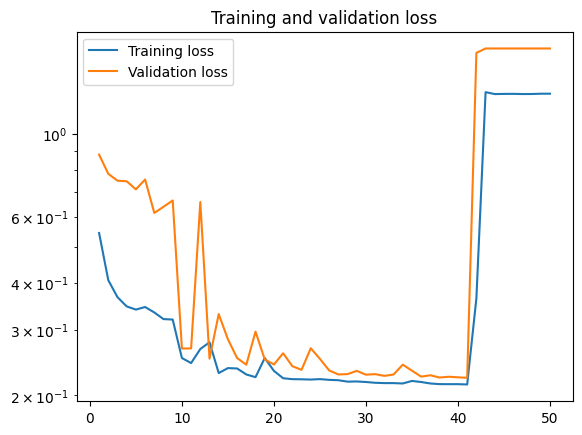

In [11]:
#Plot training and validation loss
from matplotlib import pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.yscale('log')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Input shape: (4, 512, 512, 1)
Target shape: (4, 512, 512, 1)
Input Range: min=-1.000, max=1.000, mean=-0.044
Target Mask Range: min=0.000, max=1.000, mean=0.251


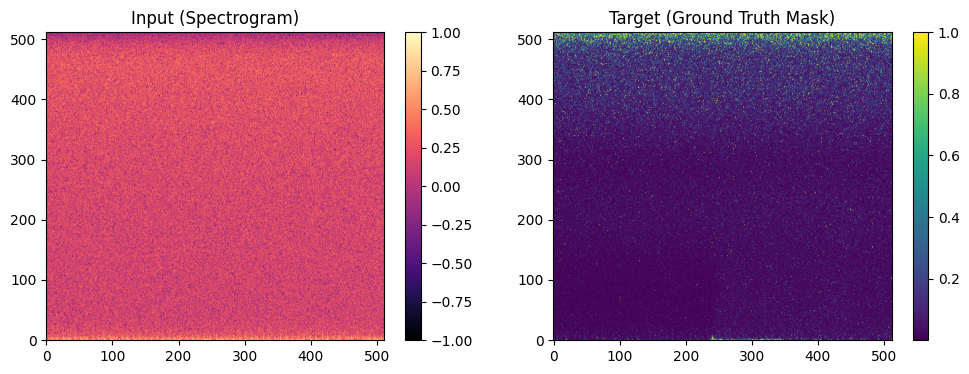

In [ ]:
test_gen = SlicedAudioGenerator(y_no_dolby, y_dolby, batch_size=4)

X_batch, Y_batch = test_gen.__getitem__(0)

print(f"Input shape: {X_batch.shape}")
print(f"Target shape: {Y_batch.shape}")

print(f"Input Range: min={X_batch.min():.3f}, max={X_batch.max():.3f}, mean={X_batch.mean():.3f}")
print(f"Target Mask Range: min={Y_batch.min():.3f}, max={Y_batch.max():.3f}, mean={Y_batch.mean():.3f}")

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.title("Input (Spectrogram)")
plt.imshow(X_batch[0, :, :, 0], aspect='auto', origin='lower', cmap='magma')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title("Target (Ground Truth Mask)")
plt.imshow(Y_batch[0, :, :, 0], aspect='auto', origin='lower', cmap='viridis')
plt.colorbar()
plt.show()

In [ ]:
X_pred_test = generator_nn.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


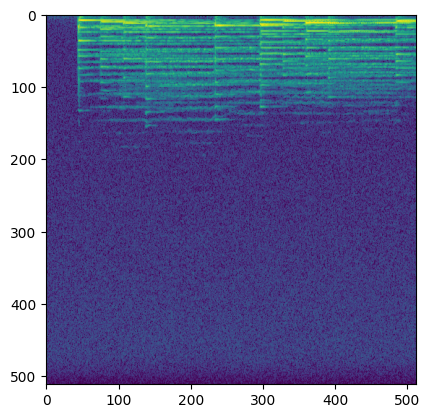

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
id = 10
plt.imshow(X_test[id,:,:,0])

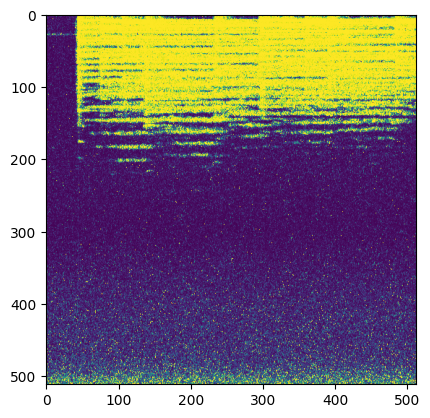

In [14]:
plt.imshow(y_test[id,:,:,0])

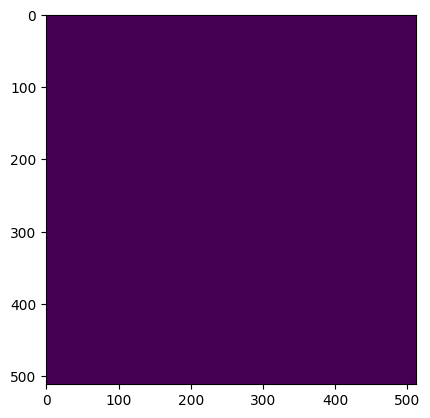

In [15]:
plt.imshow(X_pred_test[id,:,:,0])

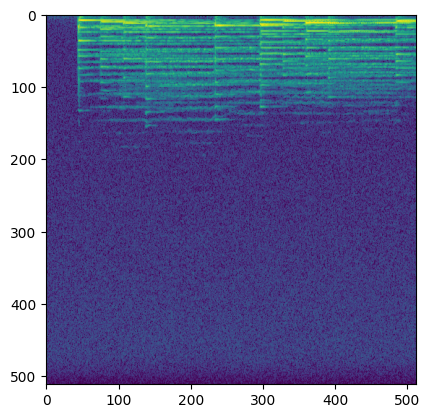

In [16]:
plt.imshow(X_test[id,:,:,0] * X_pred_test[id,:,:,0])

In [17]:
X_pred_test.max(), X_pred_test.min()

(np.float32(1.0), np.float32(1.0))

In [18]:
# generator_nn.save(root_path + 'model_best_v14.keras')
# print("Saved model to disk")

In [19]:
# Save model structure to disk
model_json = generator_nn.to_json()
with open(root_path + "mod_unet_last_weights_v16.json", "w") as json_file:
    json_file.write(model_json)

# Serialize weights to HDF5
generator_nn.save_weights(root_path + "mod_unet_last_weights_v16.weights.h5")
print("Saved model to disk (structure + weights separately)")


Saved model to disk (structure + weights separately)
